# How to match images using DELF and TensorFlow Hub


# Import libraries

In [2]:
import pandas as pd
from absl import logging

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO

import tensorflow as tf

import tensorflow_hub as hub
from six.moves.urllib.request import urlopen
import os
import re

## The data

In the next cell, we specify the URLs of two images we would like to process with DELF in order to match and compare them.

In [59]:
IMAGE_1_URL = "FC.jpeg"
IMAGE_2_URL = "F.jpeg"

Download, resize, save and display the images.

In [60]:
def download_and_resize(name, url, new_width=256, new_height=256):
  #path = tf.keras.utils.get_file(url)
  image = Image.open(url)
  image = ImageOps.fit(image, (new_width, new_height), Image.ANTIALIAS)
  return image

/tmp/ipykernel_25312/1814245700.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = ImageOps.fit(image, (new_width, new_height), Image.ANTIALIAS)


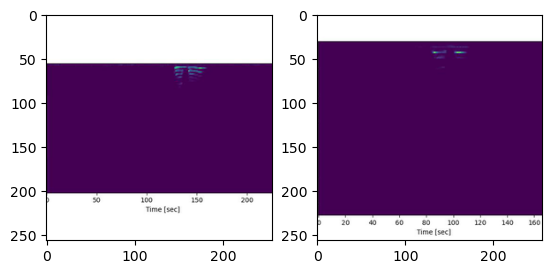

In [61]:
image1 = download_and_resize('image_1.jpg', IMAGE_1_URL)
image2 = download_and_resize('image_2.jpg', IMAGE_2_URL)


plt.subplot(1,2,1)
plt.imshow(image1)
plt.subplot(1,2,2)
plt.imshow(image2)

## Apply the DELF module to the data

The DELF module takes an image as input and will describe noteworthy points with vectors. The following cell contains the core of this colab's logic.

In [62]:
delf = hub.load('https://tfhub.dev/google/delf/1').signatures['default']

2022-10-21 02:42:38.273118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 02:42:38.273332: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-21 02:42:38.273383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-21 02:42:38.273431: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-21 02:42:38.273477: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [63]:
def run_delf(image):
  np_image = np.array(image)
  float_image = tf.image.convert_image_dtype(np_image, tf.float32)

  return delf(
      image=float_image,
      score_threshold=tf.constant(100.0),
      image_scales=tf.constant([0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0]),
      max_feature_num=tf.constant(1000))

In [64]:
result1 = run_delf(image1)
result2 = run_delf(image2)

## Use the locations and description vectors to match the images

In [65]:
#@title TensorFlow is not needed for this post-processing and visualization
def match_images(image1, image2, result1, result2):
  distance_threshold = 0.8

  # Read features.
  num_features_1 = result1['locations'].shape[0]
  print("Loaded image 1's %d features" % num_features_1)
  
  num_features_2 = result2['locations'].shape[0]
  print("Loaded image 2's %d features" % num_features_2)

  # Find nearest-neighbor matches using a KD tree.
  d1_tree = cKDTree(result1['descriptors'])
  _, indices = d1_tree.query(
      result2['descriptors'],
      distance_upper_bound=distance_threshold)

  # Select feature locations for putative matches.
  locations_2_to_use = np.array([
      result2['locations'][i,]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  locations_1_to_use = np.array([
      result1['locations'][indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])

  # Perform geometric verification using RANSAC.
  _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=1000)

  print('Found %d inliers' % sum(inliers))

  # Visualize correspondences.
  _, ax = plt.subplots()
  inlier_idxs = np.nonzero(inliers)[0]
  plot_matches(
      ax,
      image1,
      image2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='b')
  ax.axis('off')
  ax.set_title('DELF correspondences')




Loaded image 1's 12 features
Loaded image 2's 5 features
Found 5 inliers


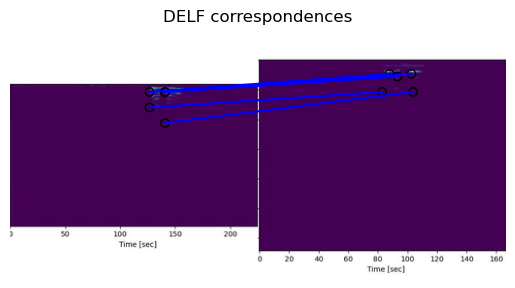

In [66]:
match_images(image1, image2, result1, result2)